In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [2]:
data = pd.read_csv('data/ALL.csv')

# DROP

## Get the quadruples with unknown OCT orientation (it is one quadruple, actually)

In [3]:
orientation_lookup = {(1, 0, 0, 0, 1, 0): 'horizontal', (0, 0, 1, 0, 1, 0): 'vertical'}
orientation_list = []
for i, row in data.iterrows():
    if row['image_type'] == 'Optical Coherence Tomography Scanner':
        if type(row['image_orientation']) is not str:
            orientation_list.append('DROP')
            continue
        orientation = tuple(round(o) for o in ast.literal_eval(row['image_orientation']))
        if orientation in orientation_lookup:
            orientation_list.append(orientation_lookup[orientation])
        else:
            orientation_list.append('DROP')
    elif row['image_type'] == 'Scanning Laser Ophthalmoscope':
        orientation_list.append('fundus')
    else:
        orientation_list.append('DROP')

In [4]:
data['image_orientation'] = orientation_list
print(data[data['image_orientation'] == 'DROP']['image_uuid'])

416     f5065b2d-adfc-467a-89bd-ba238dbb7107
688     5df11c26-323f-43aa-938e-c37ed551ca0a
1148    725afe86-c9f2-4846-913b-f6414a5a490d
1268    0798583d-46a0-45ce-b38a-9f9814ffaa17
Name: image_uuid, dtype: object


## Get the stand-alone image pairs

In [5]:
print(data[data.groupby(['patient_hash', 'acquisition_date', 'laterality'])['image_hash'].transform('count').eq(2)]['image_uuid']) # remove those with only 2 values

266     768ea9e4-21a4-490c-a95b-917e8117c03b
267     cac6e3bb-0199-4af2-9439-236de58bff1b
326     1d2eab5c-3cc0-4d41-816d-f645b2447007
327     3336fede-9d62-4c81-b540-9718c8110705
328     ad58c248-78cf-4ae8-bdf6-8e07d19bf2b3
329     ff2767cf-485b-45e0-80f8-caa91404dcb7
458     e87788e3-eb1f-4243-8640-327a4b17ec51
459     d657067c-86d7-481c-a8c6-360589e98320
482     e0bccd71-9156-421d-beb3-b572cb586d63
483     5c5397f1-9256-45ff-87d8-6833e8ea1ca2
496     4063c8af-e668-4e37-94fe-32dc0074683d
497     c15a7fa8-6c07-45dc-ad82-1ffd531de955
674     7ec2ac50-481c-4d58-950e-65e036bd7c95
675     f7b3540c-dd7e-4913-a5a0-c771586daeeb
936     e6117453-0a2a-4bd7-ab66-f2f2ffff3fbe
937     cd3fbe6e-7675-4beb-8869-ac1e3670c0a9
1108    35566f90-205d-4b1b-9cb8-28de50f6b46d
1109    c5d1b41e-5084-4765-b7ea-76d0468d5f85
1584    aa90f175-bdc7-47e2-a1e7-ff1548e7e856
1585    f70f4a70-a51f-4625-851f-31404dacab39
1744    f30c479e-2bb8-4e8f-b8eb-e6551dfee57b
1745    5e3aab60-a03e-4676-a7a8-c47bdc47e835
Name: imag

## Get duplicates
Check the duplicates manually

In [6]:
imgs = 'data/images'
def compare(data, uids):
    for uid in uids:
        image_uuids = data[data['frame_of_reference_UID'] == uid]['image_uuid'].tolist()
        orientations = data[data['frame_of_reference_UID'] == uid]['image_orientation'].tolist()
        plt.figure(figsize=(10, 5))
        for i, (uuid, orientation) in enumerate(zip(image_uuids, orientations)):
            plt.subplot(1, 2, i+1)
            img = plt.imread(imgs + '/' + uuid + '.png')
            plt.imshow(img, cmap='gray')
            plt.annotate(uuid, (0, 0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=10)
            plt.annotate(orientation, (0, 0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=10)
            plt.axis('off')

        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

In [7]:
n = 6
loop_from_2_to_n_minus_1 = 2

data_n = data[data.groupby(['patient_hash', 'acquisition_date', 'laterality'])['image_hash'].transform('count').eq(n)]
patients = data_n.groupby(['patient_hash', 'acquisition_date', 'laterality'], as_index=False).count()['patient_hash'].tolist()
patient_duplicates = dict()
for p in patients:
    data_p = data_n[data_n['patient_hash'] == p]
    ref_uids_duplicate = data_p[data_p.groupby(['image_orientation'])['frame_of_reference_UID'].transform('count').eq(loop_from_2_to_n_minus_1)]['frame_of_reference_UID'].tolist()
    print(p, ref_uids_duplicate)
    patient_duplicates[p] = ref_uids_duplicate

0e14f8f930db796cf2c6823c2247b05e ['c2036fce7b3073bd92e4adf63af28c26', 'ecbad15bd59ca69a4c5de5d0bbce1cb8']
2e0dc380591023a31fb44d8b5a972964 []
54f9e80e5a5cb0b2db39fe8a2a0188ba []
5ee081f511889e43062dc4ca6ab748ec ['1707f269abd6cfc7cc3bc5952de1b19a', '3fafcd15158a8593f002dc7a9d53d09b']
7ed76687bb10c296c655577094e27e33 ['93905527255b562c946e143e663b2ba9', 'a676be9f0f8cf7b8a9ed898e7e8d2485']
a346ee905ac76e48aa180e83175e6b3c ['40d2274fba092f44843f2cc5cfb37e94', 'f6628768571d9713711d6247efb99067']
be63aa594b405454abb886ffc60e8d8d ['65a6883ce04caf03b3ff6657c7de8e36', 'b1d47153d2af062190cbaa037a64ff58']
c801fa0f04d90e208f776f912c8b7855 ['2f4ff6bb16b46b48a1233742b7c4c4f6', 'b4c5ee83fa4fe12fb61184006c475e05']
c936531903231dfe31d14b263d032b7c ['036fa53a309b0ca9fbcedf76da14f4db', 'ff55e75f66bae25f9771b1d6fdaa4ea2']
ca44cac16f56fe732cd2dfa803dffc82 ['531b5c39a2eb1dc09f61adc8aa3b1ed2', 'f95d299b851caa5607f1494cdd7c069e']
e926c0ac3132b4123ad04078408fb2f2 ['3bd6b6cafb3f3634f16b6ad2f5e31d38', 'cbc938f36

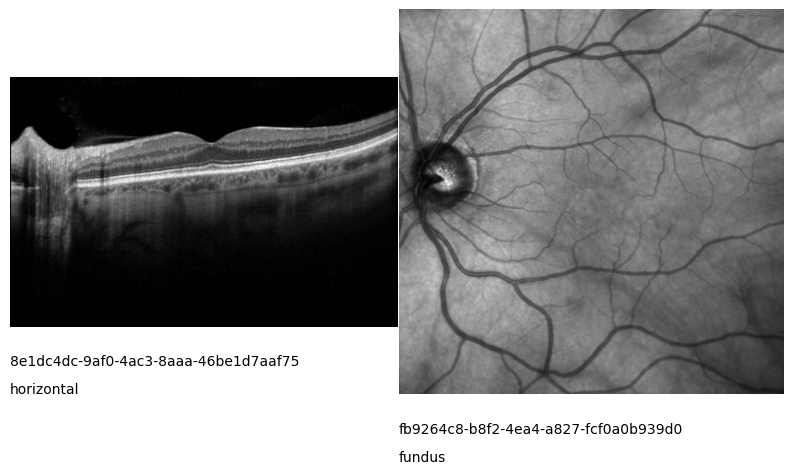

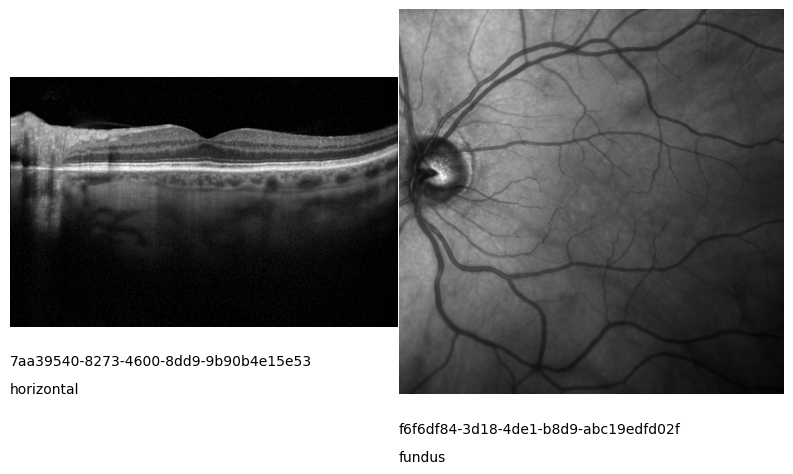

In [8]:
compare(data_n, patient_duplicates[patients[8]])

## Drop by manually defined list

In [9]:
to_drop = pd.read_excel('data/discard.xlsx')
data_clean = data[~data['image_uuid'].isin(to_drop['image_uuid'])]
display(to_drop.head())

,image_uuid,reason
0,9d6b9077-8300-4774-94d0-964d4ded9123,duplicates
1,1e9b6906-d2c0-45cd-907f-da10262f9201,duplicates
2,7050555a-dd6d-4031-ae4d-325237845d01,duplicates
3,78f5ea2d-1385-4789-8082-07f24064f5c5,duplicates
4,e92e4899-6db3-4df2-bffc-40d07c58edf3,duplicates


In [10]:
print(data.groupby(['patient_hash', 'acquisition_date', 'laterality'])['image_uuid'].count().value_counts())
print()
print(data_clean.groupby(['patient_hash', 'acquisition_date', 'laterality'])['image_uuid'].count().value_counts())

4     451
6      12
2      11
8       4
10      2
18      1
12      1
Name: image_uuid, dtype: int64

4    437
Name: image_uuid, dtype: int64


# QUADRUPLES, SUBTRIPLETS

In [14]:
data_clean.groupby(['patient_hash', 'acquisition_date', 'laterality'])['image_uuid'].count()

patient_hash                      acquisition_date                  laterality
008909bd27b680698322c750c400e4b1  5a0bef51c9e6dee843fc62c0b9aceb4c  L             4
                                                                    R             4
                                  cd640cc87e74f69ede50f06adf8b4bf6  L             4
                                                                    R             4
00eff31657d6ccd76d0a80f9e40f1f03  688e19206e820e61437ada7b84e02e7b  L             4
                                                                                 ..
fbd3a2176dc16b2bd6a483060b92637e  57b332078fd1079f0a6bc9760b88f5d8  R             4
fc3fc7e9e0d805f96c1c97c4f9cd2a1b  1d3ded1b21931e77f7173df817c480d7  R             4
fcde2c2d94cb15e2a0e3c52a56b4c9ae  eac8ff5348e00b5db2db8aacad99bf99  R             4
fdeec9ce044ab607082204888eccccbe  a8cd7b54e42db627bb0d2cd6ea340a7a  L             4
                                                                    R            

In [17]:
patient_hash = set(data_clean['patient_hash'].tolist())
for p in patient_hash:
    data_p = data_clean[data_clean['patient_hash'] == p]
    acq_dates = set(data_p['acquisition_date'].tolist())
    for a in acq_dates:
        data_a = data_p[data_p['acquisition_date'] == a]
        laterality = set(data_a['laterality'].tolist())
        for l in laterality:
            data_l = data_a[data_a['laterality'] == l]
            frame_of_reference = set(data_l['frame_of_reference_UID'].tolist())
            for f in frame_of_reference:
            
            display(data_l)

    break

,patient_hash,laterality,patient_age,frame_of_reference_UID,image_orientation,image_type,rows,columns,frames,equipment,image_hash,location,description,acquisition_date,image_uuid,proliferation
646,50c2c550f8e12edaaaf5fcc0f90005be,R,65,8a74aaf386a9f0d53b1439b1b2b2da5f,vertical,Optical Coherence Tomography Scanner,496,768,1,Spectralis,2ccfb812edccd592ad90c793aef2aca4,Retina,Section IR 30° ART,3d8268a9bbc75a8a8c2c5c72dc8fff29,5bffa6fc-3442-4821-80ab-deadfc7b8fa2,NPDR
647,50c2c550f8e12edaaaf5fcc0f90005be,R,65,8a74aaf386a9f0d53b1439b1b2b2da5f,fundus,Scanning Laser Ophthalmoscope,768,768,1,Spectralis,42d4dc1028bfa6d0f9c38074e78edb0f,Retina,Section IR 30° ART,3d8268a9bbc75a8a8c2c5c72dc8fff29,19b989ca-3f66-4715-9363-c8cfba605586,NPDR
648,50c2c550f8e12edaaaf5fcc0f90005be,R,65,aac0501ae2e997da8288b81d109594c8,horizontal,Optical Coherence Tomography Scanner,496,768,1,Spectralis,2cf11b9a077bd070540fb98737975901,Retina,Section IR 30° ART,3d8268a9bbc75a8a8c2c5c72dc8fff29,d15a2180-0065-4579-ac2f-89fb6ccefcd2,NPDR
649,50c2c550f8e12edaaaf5fcc0f90005be,R,65,aac0501ae2e997da8288b81d109594c8,fundus,Scanning Laser Ophthalmoscope,768,768,1,Spectralis,00c999e0947892692c3a4edfeed6f983,Retina,Section IR 30° ART,3d8268a9bbc75a8a8c2c5c72dc8fff29,98bee835-98f4-4946-beb8-08de4b2c5713,NPDR


In [23]:
# Create two subtriplets for each patient consisting of vertical and horizontal OCT as well as one fundus image

def create_triplets(data_l, patient_hash, acq_dates, laterality):
    triplets = []
    frame_of_reference = set(data_l['frame_of_reference_UID'].tolist())
    for f in frame_of_reference:
        tri = dict()
        for _, row in data_l.iterrows():
            if row['image_orientation'] == 'fundus' and row['frame_of_reference_UID'] != f:
                continue
            img_orientation = row['image_orientation']
            img_for = row['frame_of_reference_UID']
            img_hash = row['image_hash']
            img_uuid = row['image_uuid']
            tri[img_orientation] = (img_for, img_hash, img_uuid)

                

        triplet = {
            'patient_hash': patient_hash,
            'patient_age': data_l['patient_age'].tolist()[0],
            'acquisition_date': acq_dates,
            'laterality': laterality,
            'frame_of_reference_UID': {k: tri[k][0] for k in sorted(tri.keys())},
            'image_hash': {k: tri[k][1] for k in sorted(tri.keys())},
            'image_uuid': {k: tri[k][2] for k in sorted(tri.keys())},
            'proliferation': data_l['proliferation'].tolist()[0]
        }
        triplets.append(triplet)

    return triplets



In [24]:
triplets_list = []

for p in patient_hash:
    data_p = data_clean[data_clean['patient_hash'] == p]
    acq_dates = set(data_p['acquisition_date'].tolist())
    for a in acq_dates:
        data_a = data_p[data_p['acquisition_date'] == a]
        laterality = set(data_a['laterality'].tolist())
        for l in laterality:
            data_l = data_a[data_a['laterality'] == l]
            triplets = create_triplets(data_l, p, a, l)
            triplets_list.extend(triplets)

len(triplets_list) # Should be 2 * 437 = 874

874

In [30]:
triplets_df = pd.DataFrame(triplets_list).sort_values(by=['patient_hash', 'patient_age', 'acquisition_date', 'laterality'], ignore_index=True)
display(triplets_df.head())

,patient_hash,patient_age,acquisition_date,laterality,frame_of_reference_UID,image_hash,image_uuid,proliferation
0,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,L,"{'fundus': 'cf801454541c31d5bf68f89b0f5edd1f',...","{'fundus': 'c4136c686c707e65e3fc81b33f2d46dd',...",{'fundus': 'db6a025c-bcfa-11ed-ae99-92d06df2e3...,PDR
1,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,L,"{'fundus': '2d4081be8cd980b8db5a1d9b8d7179ee',...","{'fundus': 'd05800dff11d5119c2641cdc68f3dfbb',...",{'fundus': 'd68d4e6a-bcfa-11ed-ae99-92d06df2e3...,PDR
2,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,R,"{'fundus': 'b3fc6c1fa74905b8a5e0be20fbd2c0c9',...","{'fundus': 'da5624da9427d7d91d896dfc167bcc32',...",{'fundus': 'da7a3c7c-bcfa-11ed-ae99-92d06df2e3...,PDR
3,008909bd27b680698322c750c400e4b1,71,cd640cc87e74f69ede50f06adf8b4bf6,R,"{'fundus': '4de1200c340f9080a58f2193194d087f',...","{'fundus': 'd420e06bc5a95308dbb385d90854f0a1',...",{'fundus': 'da69d6de-bcfa-11ed-ae99-92d06df2e3...,PDR
4,008909bd27b680698322c750c400e4b1,72,5a0bef51c9e6dee843fc62c0b9aceb4c,L,"{'fundus': 'abc3d225d16cd551db44b0a6d99c5491',...","{'fundus': 'cd96b74baa6ac70163eb84ee23fcbfb5',...",{'fundus': 'da9650a6-bcfa-11ed-ae99-92d06df2e3...,PDR


# NEW CSV

In [31]:
triplets_df.to_csv('data/TRIPLETS.csv', index=False)